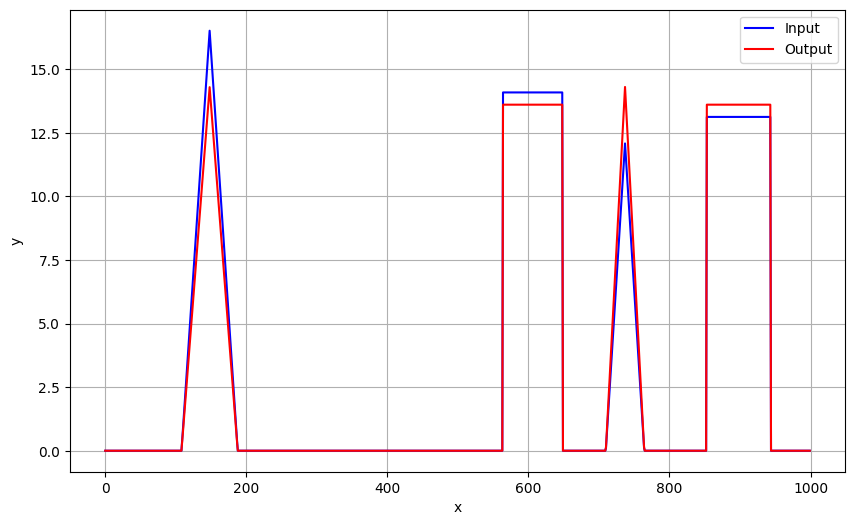

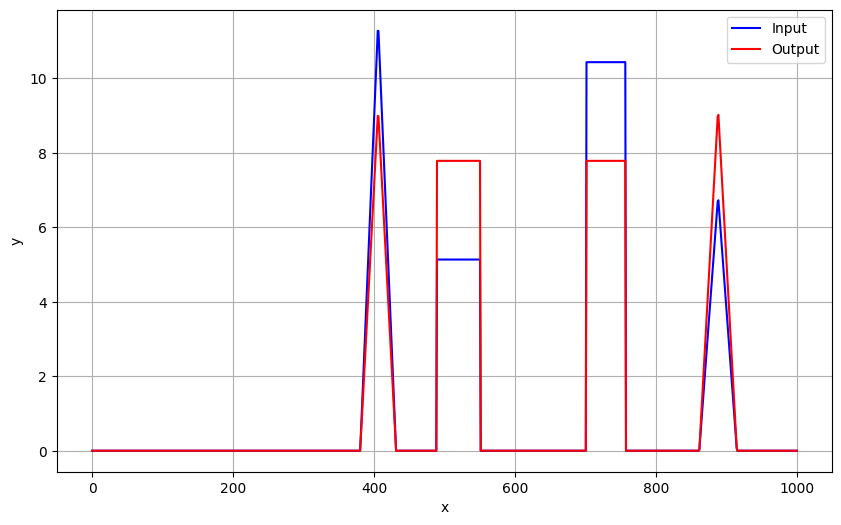

In [1]:
import shapes1d_dataset_generator as ShapeGen
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
train_on_gpu = torch.cuda.is_available()
display(train_on_gpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

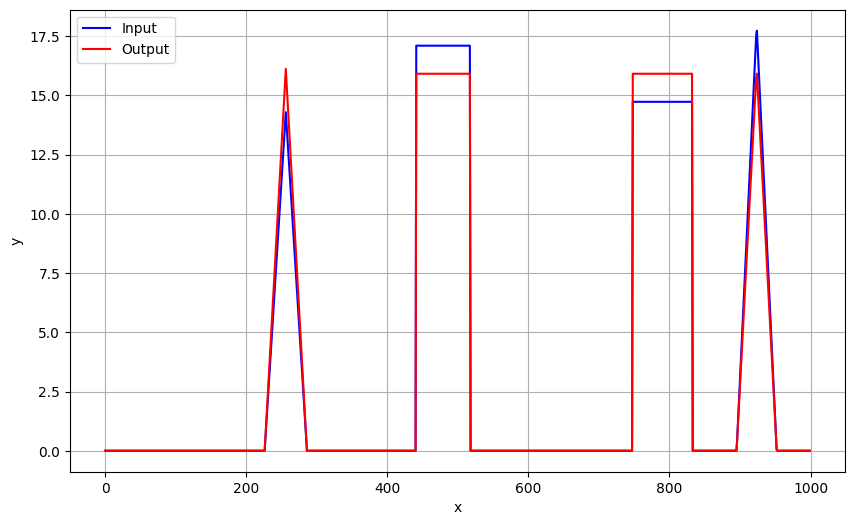

In [2]:
gen = ShapeGen.GeneratorShapes(10)
x0, y0, x, y, = gen.generate()
ShapeGen.plot_shapes(y0,y)

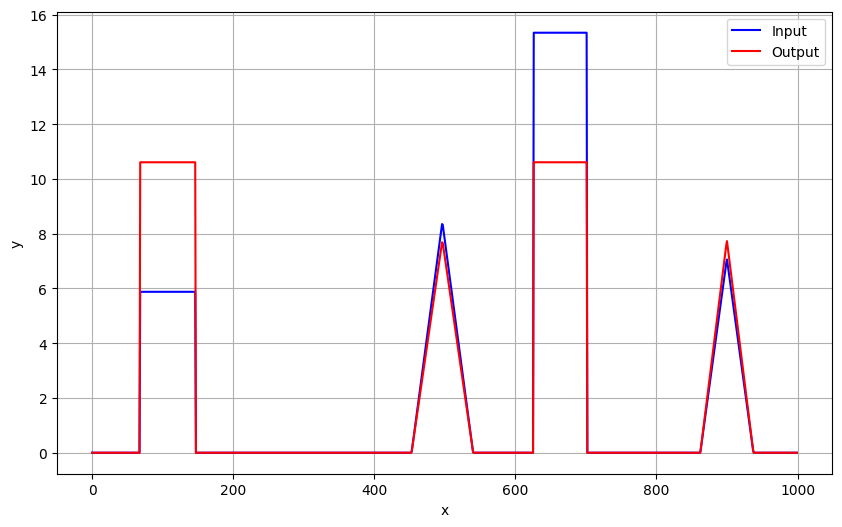

In [3]:
training_data = ShapeGen.Shapes1dDataset(10000,10)
training_loader = DataLoader(training_data, batch_size=32, shuffle=True)

_x, _y = next(iter(training_loader))
ShapeGen.plot_shapes(_x[0],_y[0])

In [ ]:
class Conv1DNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels=1,  out_channels=64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5, padding=2)
        self.conv4 = nn.Conv1d(in_channels=256, out_channels=1, kernel_size=5, padding=2)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.conv4(x)

        return x
    
class Conv1DNetWithAttention(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels=1,  out_channels=64, kernel_size=5, padding=2) #TODO CHannels anpassen
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.atn = nn.MultiheadAttention(embed_dim=128, num_heads=1) 
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5, padding=2)
        self.conv4 = nn.Conv1d(in_channels=256, out_channels=1, kernel_size=5, padding=2)

        self.relu = nn.ReLU()

    def forward(self, x, return_attention=False):

        # Stufe 1+2: Convs
        x = self.relu(self.conv1(x))  # -> [B, 32, seq_len]
        x = self.relu(self.conv2(x))  # -> [B, 64, seq_len]

        # Permute: (B, 64, seq_len) -> (seq_len, B, 64)
        x_perm = x.permute(2, 0, 1)

        # Multi-Head-Attention (Self-Attention):
        # attn_out: (seq_len, B, 64)
        # attn_weights: (B, num_heads, seq_len, seq_len)  (wegen average_attn_weights=False)
        attn_out, attn_weights = self.attention(x_perm, x_perm, x_perm)

        # Zurück in (B, 64, seq_len)
        x = attn_out.permute(1, 2, 0)

        # Stufe 3+4: Convs
        x = self.relu(self.conv3(x))  # -> [B, 128, seq_len]
        x = self.conv4(x)             # -> [B, 1, seq_len]

        if return_attention:
            return x, attn_weights
        else:
            return x

In [ ]:
def train_model(model, dataloader, num_epochs=10, lr=1e-3, device='gpu'):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for i, (x_batch, y_batch) in enumerate(dataloader):
            x_batch = x_batch.to(device)  # shape: [B, 1, seq_len]
            y_batch = y_batch.to(device)  # shape: [B, 1, seq_len]

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(dataloader)
        losses.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}")

    return losses


In [ ]:
# Wir gehen davon aus, dass 'dataloader' bereits existiert
    # oder wir generieren ihn hier nochmal kurz:
    dataset = ShapeGen.Shapes1dDataset(nsamples=2000, res=10)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Modell ohne Attention
    model_no_attn = Conv1DNetNoAttention()
    print("Training Modell ohne Attention ...")
    loss_no_attn = train_model(model_no_attn, dataloader, num_epochs=10, lr=1e-3)

    # Modell mit Attention
    model_with_attn = Conv1DNetWithAttention()
    print("\nTraining Modell mit Attention ...")
    loss_with_attn = train_model(model_with_attn, dataloader, num_epochs=10, lr=1e-3)

    # Plot der Trainingskurven
    plt.figure(figsize=(8, 6))
    plt.plot(loss_no_attn, label='Ohne Attention')
    plt.plot(loss_with_attn, label='Mit Attention')
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.title("Trainings-Verlustvergleich")
    plt.show()

    # Beispielhafte Vorhersage aus dem Trainingsset
    x_sample, y_sample = dataset[0]
    x_sample = x_sample.unsqueeze(0)  # [1, 1, seq_len]
    y_pred_no_attn = model_no_attn(x_sample).detach().squeeze(0)  # -> [1, seq_len]
    y_pred_attn = model_with_attn(x_sample).detach().squeeze(0)

    # Plotten
    plot_shapes(x_sample[0,0], y_sample[0], title="Eingabe vs. Ziel (Ground Truth)")
    plot_shapes(y_pred_no_attn[0], y_sample[0], title="Vorhersage ohne Attention vs. Ziel")
    plot_shapes(y_pred_attn[0], y_sample[0], title="Vorhersage mit Attention vs. Ziel")

In [ ]:
# Angenommen wir haben schon ein trainiertes Modell:
model_with_attn = Conv1DNetWithAttention()
# ... (Training-Code) ...
model_with_attn.eval()

# Beispiel: Ein einziges Sample aus dem Dataset
x_sample, y_sample = dataset[0]               # x_sample: [1, seq_len], y_sample: [1, seq_len]
x_sample = x_sample.unsqueeze(0)              # -> [B=1, 1, seq_len]
with torch.no_grad():
    pred, attn_weights = model_with_attn(x_sample, return_attention=True)

print("pred shape:", pred.shape)              # -> [1, 1, seq_len]
print("attn_weights shape:", attn_weights.shape)
# Mit average_attn_weights=False -> [B, num_heads, seq_len, seq_len]
# => [1, 4, seq_len, seq_len] bei num_heads=4


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_attention_weights(attn_weights):
    """
    attn_weights: Tensor der Form [B, num_heads, seq_len, seq_len]
    Wir plotten hier für B=1 jede Head-Matrix als eigenes Subplot.
    """
    # Wir nehmen an, B=1:
    attn_weights = attn_weights[0]  # => [num_heads, seq_len, seq_len]
    num_heads, seq_len, _ = attn_weights.shape

    fig, axes = plt.subplots(1, num_heads, figsize=(4 * num_heads, 4))
    if num_heads == 1:
        axes = [axes]  # damit wir es einheitlich behandeln
    
    for h in range(num_heads):
        # Hole die Attention-Matrix dieses Heads (seq_len, seq_len)
        attn = attn_weights[h].detach().cpu().numpy()

        # Plot als Heatmap
        ax = axes[h]
        im = ax.imshow(attn, cmap="viridis", aspect='auto')
        ax.set_title(f"Head {h}")
        ax.set_xlabel("Key/Value Position")
        ax.set_ylabel("Query Position")
        fig.colorbar(im, ax=ax)

    fig.suptitle("Attention Weights Heatmap pro Head", fontsize=16)
    plt.tight_layout()
    plt.show()

# Beispielhafter Aufruf nach dem Forward-Pass:
plot_attention_weights(attn_weights)


In [ ]:
Attention weight heatmeap
# attentionsweight in var speicher bei forward
tru and false für attention
